In [1]:
import datetime
import os
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some,plot_history
import matplotlib.pyplot as plt
from actin_tubules_sim.models import DFCAN
from actin_tubules_sim.loss import mse_ssim
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model


In [2]:
root_dir = '/Users/vkapoor/Downloads/Microtubules'
model_dir = Path(root_dir)/'SRModel'
Path(model_dir).mkdir(exist_ok=True)
train_data_file = f'{root_dir}/Train/SR/microtubule_sr_training_data.npz'
log_dir = "logs/fitSR/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data(train_data_file, validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
X = tf.squeeze(X, axis=-1)
X_val = tf.squeeze(X_val, axis=-1)
Y = tf.squeeze(Y, axis=-1)
Y_val = tf.squeeze(Y_val, axis=-1)
X = tf.transpose(X, perm=[0, 2, 3, 1])
X_val = tf.transpose(X_val, perm=[0, 2, 3, 1])

Y = tf.transpose(Y, perm=[0, 2, 3, 1])

Y_val = tf.transpose(Y_val, perm=[0, 2, 3, 1])




number of training images:	 495
number of validation images:	 55
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


2024-06-26 14:37:13.387313: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-26 14:37:13.387338: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-26 14:37:13.387349: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-26 14:37:13.387383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-26 14:37:13.387399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
X.shape,Y.shape,X_val.shape

(TensorShape([495, 128, 128, 9]),
 TensorShape([495, 256, 256, 1]),
 TensorShape([55, 128, 128, 9]))

Text(0.5, 0.98, '5 example validation patches (top row: source, bottom row: target)')

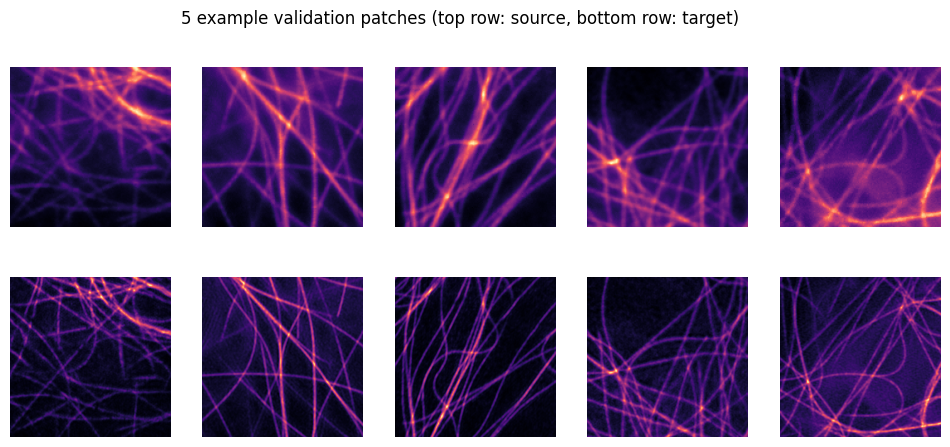

In [5]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)')

In [6]:
init_lr = 1e-4
batch_size = 3
epochs = 10
beta_1=0.9
beta_2=0.999
scale_gt = 2.0

total_data,  height, width, channels= X.shape

In [9]:
Trainingmodel = DFCAN((height, width, channels), scale=scale_gt)
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel.compile(loss=mse_ssim, optimizer=optimizer)
Trainingmodel.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()
srate = callbacks.ModelCheckpoint(
            str(model_dir),
            monitor="loss",
            save_best_only=False,
            save_weights_only=False,
            mode="auto",
        )


(None, 128, 128, 9)


Tensor("Placeholder:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 9)]        0         []                            
                                                                                                  
 conv2d_83 (Conv2D)          (None, 128, 128, 64)         5248      ['input_2[0][0]']             
                                                                                                  
 lambda_83 (Lambda)          (None, 128, 128, 64)         0         ['conv2d_83[0][0]']           
                                                                                                  
 conv2d_84 (Conv2D)          (None, 128, 128, 64)         36928     ['lambda_83[0][0]']           
                    

## Training
Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which allows you to inspect the losses during training.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.` Then connect to http://localhost:6006/ with your browser.

In [10]:
if len(os.listdir(model_dir)) > 0:

  with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
    if len(os.listdir(model_dir)) > 0:
        print(f'Loading model from {model_dir}')
        Trainingmodel = load_model(model_dir)
history = Trainingmodel.fit(X, Y, batch_size=batch_size,
                               epochs=epochs, validation_data=(X_val, Y_val), shuffle=True,
                               callbacks=[lrate, hrate, srate, tensorboard_callback])


Trainingmodel.save(model_dir)

Epoch 1/10
Tensor("model_1/lambda_164/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0
Tensor("model_1/lambda_164/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0


2024-06-26 14:41:37.777390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-26 14:41:38.535016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


165/165 [==============================] - ETA: 0s - loss: 0.0666Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 389s 2s/step - loss: 0.0666 - val_loss: 0.0270 - lr: 1.0000e-04
Epoch 2/10
165/165 [==============================] - ETA: 0s - loss: 0.0211Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 380s 2s/step - loss: 0.0211 - val_loss: 0.0319 - lr: 1.0000e-04
Epoch 3/10
165/165 [==============================] - ETA: 0s - loss: 0.0193Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 378s 2s/step - loss: 0.0193 - val_loss: 0.0200 - lr: 1.0000e-04
Epoch 4/10
165/165 [==============================] - ETA: 0s - loss: 0.0168Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 425s 3s/step - loss: 0.0168 - val_loss: 0.0181 - lr: 1.0000e-04
Epoch 5/10
165/165 [==============================] - ETA: 0s - loss: 0.0154Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 395s 2s/step - loss: 0.0154 - val_loss: 0.0179 - lr: 1.0000e-04
Epoch 6/10
165/165 [==============================] - ETA: 0s - loss: 0.0154Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 680s 4s/step - loss: 0.0154 - val_loss: 0.0173 - lr: 1.0000e-04
Epoch 7/10
165/165 [==============================] - ETA: 0s - loss: 0.0148Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 726s 4s/step - loss: 0.0148 - val_loss: 0.0169 - lr: 1.0000e-04
Epoch 8/10
165/165 [==============================] - ETA: 0s - loss: 0.0149Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 1018s 6s/step - loss: 0.0149 - val_loss: 0.0159 - lr: 1.0000e-04
Epoch 9/10
165/165 [==============================] - ETA: 0s - loss: 0.0143Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 1152s 7s/step - loss: 0.0143 - val_loss: 0.0197 - lr: 1.0000e-04
Epoch 10/10
165/165 [==============================] - ETA: 0s - loss: 0.0146Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


165/165 [==============================] - 1117s 7s/step - loss: 0.0146 - val_loss: 0.0164 - lr: 1.0000e-04
Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/SRModel/assets


['loss', 'lr', 'val_loss']


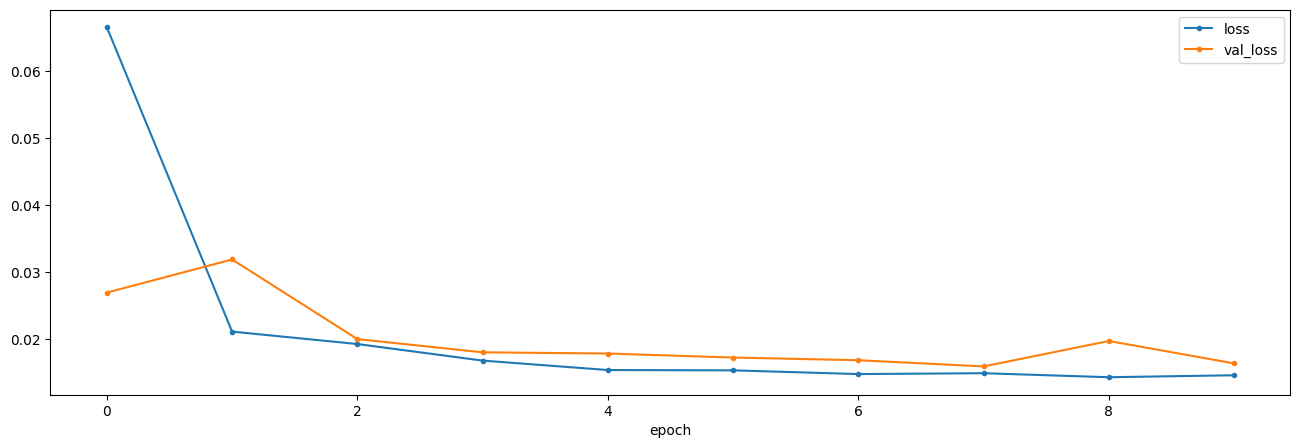

In [11]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'])

Tensor("model_1/lambda_164/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
1/1 [==============================] - 18s 18s/step


Text(0.5, 0.98, '5 example validation patches\ntop row: input (source),  middle row: target (ground truth),  bottom row: predicted from source')

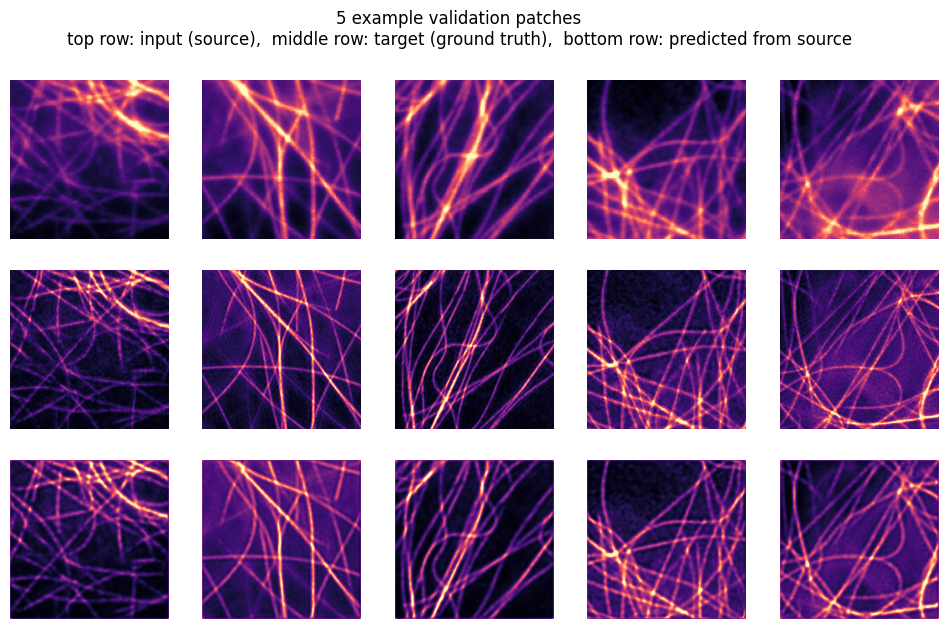

In [12]:
plt.figure(figsize=(12,7))
_P = Trainingmodel.predict(X_val[:5])

plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source')